This notebook is the implementation of a trend-following type strategy using EMA, MACD and ADX indicators. It has Reliance and Tata Motors, by default, as the stocks under consideration for the period - 1st Jan, 2020 to 1st Jan 2025

In [2]:
# import necessary libraries
import yfinance as yf # for downloading data
import talib # for data manipulation
import pandas as pd # for data storage
import matplotlib.pyplot as plt # for graphs
from backtesting import Backtest, Strategy # for backtesting
import warnings # removes warnings in the output - for clean output
# make sure graphs appear in this window
%matplotlib inline
plt.style.use("seaborn-v0_8") # set style for graph
warnings.filterwarnings('ignore') # avoid printing warnings

C:\Users\Lenovo\anaconda3\envs\DEV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Lenovo\anaconda3\envs\DEV\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

First, we should download the data using yfinance library by yahoo finance for specified period of time, here 1st Jan, 2020 to 1st Jan 2025. It also saves it as CSV ( in the same path as this notebook ) for preventing repeated API calls and reusing the data once downloaded by reading that CSV.

In [4]:
# choose some good stocks
stocks = [
    'RELIANCE.NS',      # Reliance Industries
    'TATAMOTORS.NS',    # Tata Motors
    'ICICIBANK.NS',     # ICICI Bank
    'HDFCBANK.NS',      # HDFC Bank
    'TCS.NS',           # Tata Consultancy Services
    'INFY.NS',          # Infosys
    'ITC.NS',           # ITC Ltd
    'SBIN.NS',          # State Bank of India
    'BHARTIARTL.NS',    # Bharti Airtel
    'DRREDDY.NS'        # Dr. Reddy's Laboratories
] # tickers for prominent companies

In [5]:
# download for the first time, then use csv to prevent reaching API limit
# data = yf.download(stocks,
#                    start = '2020-01-01',
#                    end = '2025-01-01',
#                    auto_adjust = True
#                    )

In [6]:
# convert the data to csv after downloading once for future use
# data.to_csv("Stocks-Data.csv")

In [7]:
# read the csv and store in "data" dataframe
# header = [0,1] makes the header more clean by reading first two rows as header - 0th and 1st
# index_col = [0] sets the 0th column as index column
# parse_dates = [0] suggests that 0th column contains dates
data = pd.read_csv("Stocks-Data.csv", header = [0,1], index_col = [0], parse_dates = [0])

In [8]:
# print data for intuition
data

Price              Close                                                      \
Ticker     BHARTIARTL.NS   DRREDDY.NS  HDFCBANK.NS ICICIBANK.NS      INFY.NS   
Date                                                                           
2020-01-01    436.938965   569.343506  1227.428711   518.854004   655.615356   
2020-01-02    438.770386   566.476318  1235.252441   522.575623   653.702393   
2020-01-03    438.673981   570.233276  1217.636963   520.883972   663.756531   
2020-01-06    433.420685   569.234741  1191.285278   508.172424   657.394897   
2020-01-07    429.034912   570.292542  1210.148926   505.465851   647.652100   
...                  ...          ...          ...          ...          ...   
2024-12-24   1583.900024  1350.900024  1798.099976  1297.250000  1909.050049   
2024-12-26   1599.500000  1355.150024  1790.750000  1297.349976  1907.400024   
2024-12-27   1599.849976  1389.449951  1798.250000  1307.550049  1916.750000   
2024-12-30   1586.900024  1376.900024  1777.900024  1294.650024  1906.000000   
2024-12-31   1587.750000  1388.500000  1772.849976  1281.650024  1880.000000   

Price                                                                       \
Ticker          ITC.NS  RELIANCE.NS     SBIN.NS TATAMOTORS.NS       TCS.NS   
Date                                                                         
2020-01-01  190.004684   683.001709  308.602570    183.311234  1944.476440   
2020-01-02  191.401199   694.629456  313.077728    192.553818  1935.550781   
2020-01-03  190.323853   695.466431  307.910492    189.920181  1974.124512   
2020-01-06  187.610672   679.337036  294.346619    184.503815  1973.945801   
2020-01-07  187.810150   689.788330  293.792938    183.559677  1978.789429   
...                ...          ...         ...           ...          ...   
2024-12-24  471.015320  1222.750000  796.065369    736.099976  4113.920410   
2024-12-26  469.538635  1216.550049  796.457520    740.799988  4103.683594   
2024-12-27  471.162994  1221.050049  783.909485    750.500000  4099.500488   
2024-12-30  469.587830  1210.699951  772.782837    733.650024  4093.545166   
2024-12-31  476.134491  1215.449951  779.301941    740.150024  4030.549561   

Price       ...        Volume                                               \
Ticker      ... BHARTIARTL.NS DRREDDY.NS HDFCBANK.NS ICICIBANK.NS  INFY.NS   
Date        ...                                                              
2020-01-01  ...       5154996     773895     1836849      7642793  2112415   
2020-01-02  ...       4933053    1494155     3068583     10264223  5658200   
2020-01-03  ...       5154587    1723390     5427775      9594690  7882938   
2020-01-06  ...       7538915    1788685     5445093     12534334  6519403   
2020-01-07  ...       4353883    1788175     7362247     16101835  7899363   
...         ...           ...        ...         ...          ...      ...   
2024-12-24  ...       3610076    2587142     7242917      7138516  2360544   
2024-12-26  ...       3400479    1531359     5240839      7338444  3623321   
2024-12-27  ...       2559578    3656253     3629665      4756066  3937500   
2024-12-30  ...       4438130    2462657    11111109     14207425  7789055   
2024-12-31  ...       2249626    1892083     7058618      8449607  3613063   

Price                                                              
Ticker        ITC.NS RELIANCE.NS   SBIN.NS TATAMOTORS.NS   TCS.NS  
Date                                                               
2020-01-01   4208837    14004468  17379320      25968357  1354908  
2020-01-02   8402979    17710316  20324236      57289863  2380752  
2020-01-03   9284478    20984698  21853208      47572728  4655761  
2020-01-06   7636617    24519177  35645325      28621212  3023209  
2020-01-07   8416741    16683622  50966826      34995035  2429317  
...              ...         ...       ...           ...      ...  
2024-12-24  11564497     6734917  10602771      12553555  1181886  
2024-12-26   

Now we change our columns from MultiIndex to Index, i.e. multiple rows (levels) as header to a single row which combines title from all the rows. We also select what columns (datafields) we want to work with and store them, here we need all of them. We can also drop NaN values so that the data is clean

In [10]:
# convert from multiIndex to Index
data.columns = data.columns.to_flat_index()

# select columns to work with and store them in variables
# close = data.loc[:,'Close'].copy()

# drop NaN values
data.dropna(inplace = True)

In [11]:
# see all the columns (datafields) available as Index
data.columns

Index([ ('Close', 'BHARTIARTL.NS'),     ('Close', 'DRREDDY.NS'),
          ('Close', 'HDFCBANK.NS'),   ('Close', 'ICICIBANK.NS'),
              ('Close', 'INFY.NS'),         ('Close', 'ITC.NS'),
          ('Close', 'RELIANCE.NS'),        ('Close', 'SBIN.NS'),
        ('Close', 'TATAMOTORS.NS'),         ('Close', 'TCS.NS'),
         ('High', 'BHARTIARTL.NS'),      ('High', 'DRREDDY.NS'),
           ('High', 'HDFCBANK.NS'),    ('High', 'ICICIBANK.NS'),
               ('High', 'INFY.NS'),          ('High', 'ITC.NS'),
           ('High', 'RELIANCE.NS'),         ('High', 'SBIN.NS'),
         ('High', 'TATAMOTORS.NS'),          ('High', 'TCS.NS'),
          ('Low', 'BHARTIARTL.NS'),       ('Low', 'DRREDDY.NS'),
            ('Low', 'HDFCBANK.NS'),     ('Low', 'ICICIBANK.NS'),
                ('Low', 'INFY.NS'),           ('Low', 'ITC.NS'),
            ('Low', 'RELIANCE.NS'),          ('Low', 'SBIN.NS'),
          ('Low', 'TATAMOTORS.NS'),           ('Low', 'TCS.NS'),
         ('Open', 'BHARTI

Now we should try to visualize and inspect the nature of data with the help of various metrics and graphs.

In [13]:
# see property of values contained in data
data.describe()

,"(Close, BHARTIARTL.NS)","(Close, DRREDDY.NS)","(Close, HDFCBANK.NS)","(Close, ICICIBANK.NS)","(Close, INFY.NS)","(Close, ITC.NS)","(Close, RELIANCE.NS)","(Close, SBIN.NS)","(Close, TATAMOTORS.NS)","(Close, TCS.NS)",...,"(Volume, BHARTIARTL.NS)","(Volume, DRREDDY.NS)","(Volume, HDFCBANK.NS)","(Volume, ICICIBANK.NS)","(Volume, INFY.NS)","(Volume, ITC.NS)","(Volume, RELIANCE.NS)","(Volume, SBIN.NS)","(Volume, TATAMOTORS.NS)","(Volume, TCS.NS)"
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,...,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03
mean,810.227169,982.217260,1426.808078,778.041199,1343.889590,290.525756,1106.462393,479.105924,478.699649,3108.862226,...,1.113490e+07,3.604819e+06,1.335072e+07,1.964223e+07,7.520991e+06,2.002941e+07,1.951391e+07,2.913979e+07,3.297226e+07,2.690816e+06
std,338.065526,186.284851,216.931454,268.619144,342.486206,119.506580,231.184222,193.421772,278.253352,669.271269,...,1.341948e+07,5.066464e+06,1.238253e+07,1.382091e+07,5.208159e+06,1.580310e+07,1.612248e+07,2.565880e+07,3.704278e+07,1.672086e+06
min,384.722321,518.833313,736.975586,274.531097,468.411102,117.506050,399.978638,139.191803,64.896851,1481.994019,...,2.794410e+05,1.041800e+05,5.484040e+05,1.007022e+06,3.719660e+05,1.461602e+06,1.705656e+06,1.637141e+06,2.871205e+06,1.548950e+05
25%,539.643188,863.214996,1346.668945,587.958054,1209.494446,181.146805,962.343246,340.274811,296.222298,2849.077576,...,4.551304e+06,1.527181e+06,6.625964e+06,1.097457e+07,4.692584e+06,9.973665e+06,1.009199e+07,1.277466e+07,1.091357e+07,1.661345e+06
50%,718.845947,946.953400,1460.287292,776.851593,1405.982178,253.045502,1126.790771,482.967407,431.096909,3153.382812,...,7.148218e+06,2.272828e+06,1.058592e+07,1.521360e+07,6.272753e+06,1.570078e+07,1.425293e+07,1.876771e+07,1.795474e+07,2.234917e+06
75%,909.792419,1115.817474,1582.268402,944.918671,1567.304260,416.722290,1229.855347,572.933228,626.367081,3495.810181,...,1.311232e+07,3.978495e+06,1.693303e+07,2.340348e+07,8.730180e+06,2.374741e+07,2.203644e+07,3.823175e+07,4.307979e+07,3.172765e+06
max,1771.099976,1412.489990,1871.750000,1346.099976,1999.699951,514.626953,1595.484985,887.822937,1161.849976,4471.390137,...,1.985470e+08,1.099354e+08,2.226710e+08,1.259394e+08,9.043211e+07,1.492389e+08,1.426834e+08,2.149557e+08,3.905778e+08,1.983933e+07


In [14]:
# defining a function to extract values of different datafields from dataframe to seperate variables
def extract_df(df, field):
    # store datafield values in a variable and rename columns by removing the name of datafield
    cols = [col for col in df.columns if col[0] == field]
    ret_df = df[cols]
    for datafield in ret_df.columns:
        ret_df.rename(columns = {datafield: datafield[1]}, inplace = True)
    return ret_df

In [15]:
# using the helper function to extract all datafields for various kind of visualization
# and comparision between different stocks
open = extract_df(data, 'Open')
close = extract_df(data, 'Close')
high = extract_df(data, 'High')
low = extract_df(data, 'Low')
vol = extract_df(data, 'Volume')

In [16]:
close

,BHARTIARTL.NS,DRREDDY.NS,HDFCBANK.NS,ICICIBANK.NS,INFY.NS,ITC.NS,RELIANCE.NS,SBIN.NS,TATAMOTORS.NS,TCS.NS
Date,,,,,,,,,,
2020-01-01,436.938965,569.343506,1227.428711,518.854004,655.615356,190.004684,683.001709,308.602570,183.311234,1944.476440
2020-01-02,438.770386,566.476318,1235.252441,522.575623,653.702393,191.401199,694.629456,313.077728,192.553818,1935.550781
2020-01-03,438.673981,570.233276,1217.636963,520.883972,663.756531,190.323853,695.466431,307.910492,189.920181,1974.124512
2020-01-06,433.420685,569.234741,1191.285278,508.172424,657.394897,187.610672,679.337036,294.346619,184.503815,1973.945801
2020-01-07,429.034912,570.292542,1210.148926,505.465851,647.652100,187.810150,689.788330,293.792938,183.559677,1978.789429
...,...,...,...,...,...,...,...,...,...,...
2024-12-24,1583.900024,1350.900024,1798.099976,1297.250000,1909.050049,471.015320,1222.750000,796.065369,736.099976,4113.920410
2024-12-26,1599.500000,1355.150024,1790.750000,1297.349976,1907.400024,469.538635,1216.550049,796.457520,740.799988,4103.683594
2024-12-27,1599.849976,1389.449951,1798.250000,1307.550049,1916.750000,471.162994,1221.050049,783.909485,750.500000,4099.500488


In [17]:
# define a function to plot various datafields
def plot_df(df):
    df.plot(figsize = (15,8), fontsize=12) # plots the graph with specified plot and font size
    plt.legend(fontsize = 12) # shows legends
    plt.show() # makes the plot visible

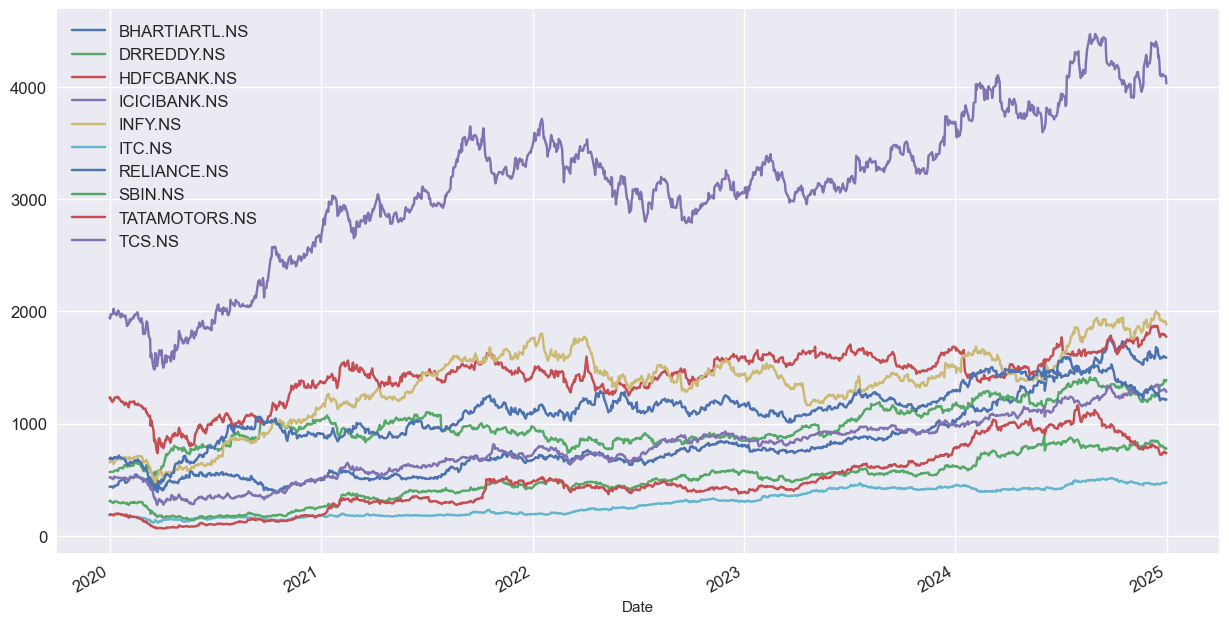

In [18]:
# now plotting these close values to see price movements of the selected stocks
plot_df(close)

The values plotted above are absolute and are not normalized, so not much can be inferred with this plot. Let's normalize these values and then plot them.

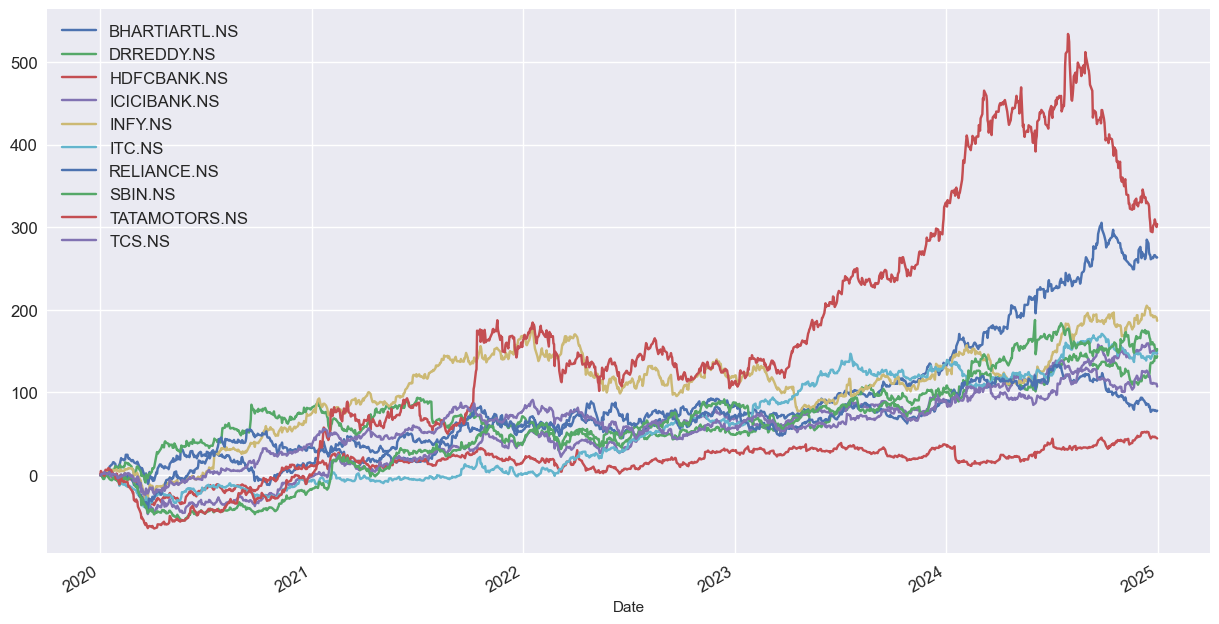

In [20]:
# defining a function to normalize datafields
# for normailzation-
# divide the column by initial value,
# subtract 1 to center it around 0 (or to represent change instead of absolute value
# and multiply by 100
def normalize_df(df):
    return 100*(df.div(df.iloc[0])-1)

close_norm = normalize_df(close)

# now plotting the normalized data
plot_df(close_norm)

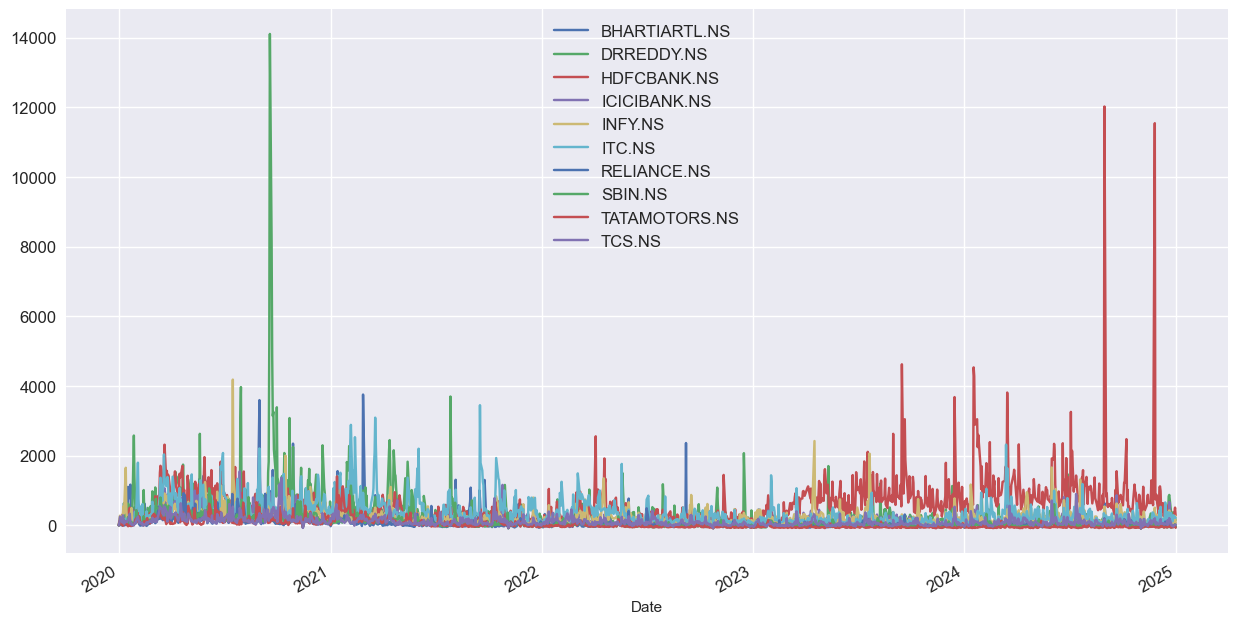

In [21]:
# similarly we can plot normalized volumes
plot_df(normalize_df(vol))

As we see, Tata Motors is performing much better as compared to others, when viewed from the viewpoint that we need to implement trend following strategy because - 
1. It has stronger price moves,
2. Higher volatility indicating greater profit generating prospects

so we will implement our strategy on that.

In [23]:
selcted_stock = "TATAMOTORS.NS"

In [24]:
# defining a function to extract values of a single stock from dataframe to seperate dataframe
def extract_stock(df, ticker, col_is_tuple = False):
    # store stock's values in a variable and rename columns by removing ticker
    if(col_is_tuple):
        cols = [col for col in df.columns if col[1] == ticker]
    else:
        cols = [col for col in df.columns if col == ticker]
    ret_df = df[cols]
    if(col_is_tuple):
        for datafield in ret_df.columns:
            ret_df.rename(columns = {datafield: datafield[0]}, inplace = True)
    return ret_df

In [25]:
data = extract_stock(data, selcted_stock, True)
open = extract_stock(open, selcted_stock)
close = extract_stock(close, selcted_stock)
high = extract_stock(high, selcted_stock)
low = extract_stock(low, selcted_stock)
vol = extract_stock(vol, selcted_stock)

In [26]:
data

,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,183.311234,185.547342,182.466490,184.006909,25968357
2020-01-02,192.553818,193.497950,183.460314,183.857839,57289863
2020-01-03,189.920181,194.442078,188.081597,191.709056,47572728
2020-01-06,184.503815,189.820791,183.907528,189.820791,28621212
2020-01-07,183.559677,188.230657,181.174501,185.845480,34995035
...,...,...,...,...,...
2024-12-24,736.099976,745.299988,722.500000,723.500000,12553555
2024-12-26,740.799988,747.799988,735.549988,736.099976,9343210
2024-12-27,750.500000,766.849976,745.700012,749.000000,15835079


Now that we have selected the stock upon which we intend to trade, let's define our strategy. We will implement our strategy by extending Strategy class of backtesting library. And then, we will backtest our strategy using the same backtesting library and evaluate the results.

In [28]:
# define helper functions to check crossover and crossunder
def crossover(a, b):
    return (a[-1] > b[-1]) & (a[-2] <= b[-2])

def crossunder(a, b):
    return (a[-1] < b[-1]) & (a[-2] >= b[-2])

In [29]:
class TrendFollow(Strategy):
    
    # strategy parameters
    ema_fast_period = 9
    ema_slow_period = 24
    adx_threshold = 25 # (experimented with various values, 25 seemed to work)
    atr_period = 14
    volume_spike = 1.01  # 1% volume increase
    atr_stop_mult = 1.3 # (experimented with various values, 1.3 seemed to work)
    atr_tp_mult = 2.3 # (experimented with various values, 2.3 seemed to work)

    def init(self):
        
        # convert to numpy array, as required by talib library
        close_array = close.to_numpy().astype('float64').flatten()
        high_array = high.to_numpy().astype('float64').flatten()
        low_array = low.to_numpy().astype('float64').flatten()
        vol_array = vol.to_numpy().astype('float64').flatten()
        
        # calculate indicators
        # EMA - fast and slow
        # using self.I so that values are calculate dynamically
        self.ema_fast = self.I(talib.EMA, close_array, self.ema_fast_period)
        self.ema_slow = self.I(talib.EMA, close_array, self.ema_slow_period)

        # MACD - MACD line and MACD signal line
        macd, macd_signal, macd_hist = talib.MACD(close_array, 12, 26, 9)
        self.macd_line = self.I(lambda: macd, name='MACD')
        self.macd_signal = self.I(lambda: macd_signal, name='MACD Signal')

        # ADX, +DI, -DI, ATR, RSI
        self.adx = self.I(talib.ADX, high_array, low_array, close_array, 14)
        self.plus_di = self.I(talib.PLUS_DI, high_array, low_array, close_array, 14)
        self.minus_di = self.I(talib.MINUS_DI, high_array, low_array, close_array, 14)
        self.atr = self.I(talib.ATR, high_array, low_array, close_array, self.atr_period)
        
        # taking volume and it's SMA
        self.volume = vol_array
        self.vol_sma = self.I(lambda: talib.SMA(self.volume, 3), name = 'Volume SMA3')

    def next(self):

        # storing index of latest data point
        i = len(self.data) - 1
        
        # check for volume spike
        # will be used as one of the entry condition
        volume_condition = True
        if i >= 5:
            volume_condition = (self.volume[i] > 
                               self.vol_sma * self.volume_spike)

        # entry conditions
        # entry condition for longing the stock
        long_entry = (
            (crossover(self.ema_fast, self.ema_slow) or
            crossover(self.macd_line, self.macd_signal)) and
            self.adx[i] > self.adx_threshold and
            self.plus_di[i] > self.minus_di[i] and
            volume_condition
        )

        # entry condition for shorting the stock
        short_entry = (
            (crossunder(self.ema_fast, self.ema_slow) or
            crossunder(self.macd_line, self.macd_signal)) and
            self.adx[i] > self.adx_threshold and
            self.minus_di[i] > self.plus_di[i] and
            volume_condition
        )

        # handling entry
        # signal to buy
        if long_entry and not self.position.is_long:

            # close the position if short
            if self.position.is_short:
                self.position.close()

            # buy with the specified stop-loss (sl) and take-profit (tp)
            self.buy(sl=self.data.Close[i] - self.atr_stop_mult * self.atr[i],
                     tp=self.data.Close[i] + self.atr_tp_mult * self.atr[i])

        # similarly, signal to sell
        elif short_entry and not self.position.is_short:

            # close the position if short
            if self.position.is_long:
                self.position.close()

            # sell with the specified stop-loss (sl) and take-profit (tp)
            self.sell(sl=self.data.Close[i] + self.atr_stop_mult * self.atr[i],
                      tp=self.data.Close[i] - self.atr_tp_mult * self.atr[i])

        
        # handling exit
        # exit condition when the position is long
        if self.position.is_long:
            # trail stop loss at 2x ATR - secures the unrealized profit while aiming more
            # exit when trend weakens, i.e. ADX<20 (experimented with various values, 20 seemed to work)
            trailing_stop = self.data.Close[i-1] - self.atr_stop_mult * self.atr[i]
            if self.data.Close[i] < trailing_stop or self.adx[i] < 20:
                self.position.close()

        # similarly, exit condition when the position is short
        elif self.position.is_short:
            trailing_stop = self.data.Close[i-1] + self.atr_stop_mult * self.atr[i]
            if self.data.Close[i] > trailing_stop or self.adx[i] < 20:
                self.position.close()

In [30]:
# create backtesting instance
bt = Backtest(
    data, 
    TrendFollow, 
    cash=100000, 
    commission=.002
)

# run backtest
results = bt.run()
bt.plot()
print(results)

Start                     2020-01-01 00:00:00
End                       2024-12-31 00:00:00
Duration                   1826 days 00:00:00
Exposure Time [%]                   11.308562
Equity Final [$]                148613.696075
Equity Peak [$]                  150869.34848
Return [%]                          48.613696
Buy & Hold Return [%]              303.766867
Return (Ann.) [%]                    8.398503
Volatility (Ann.) [%]               12.650192
Sharpe Ratio                         0.663903
Sortino Ratio                        1.267694
Calmar Ratio                         0.775884
Max. Drawdown [%]                  -10.824428
Avg. Drawdown [%]                   -5.407248
Max. Drawdown Duration      633 days 00:00:00
Avg. Drawdown Duration      133 days 00:00:00
# Trades                                   19
Win Rate [%]                        57.894737
Best Trade [%]                      16.191371
Worst Trade [%]                    -10.829556
Avg. Trade [%]                    

Now, we should save the results of our backtesting for future reference

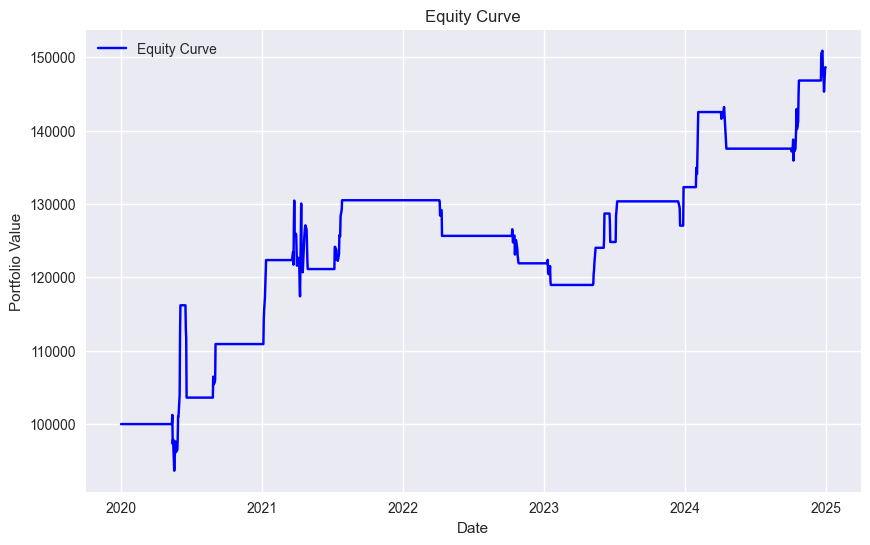

In [32]:
# save backtest statistics to CSV
results.to_csv('Backtest-Results.csv')

# access the equity curve from the Backtest object
equity_curve = results._equity_curve

# plot and save the equity curve
plt.figure(figsize=(10, 6))
plt.plot(equity_curve.index, equity_curve['Equity'], label='Equity Curve', color='blue')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.savefig('Equity-Curve.png')  # Save the plot as an image
plt.show()  # Display the plot